# EOEPCA Data Access Validation and Usage Notebook

## Setup

In [1]:
import os
import requests
import json
import matplotlib.pyplot as plt
from PIL import Image

from owslib.csw import CatalogueServiceWeb
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import lxml.etree
from tifffile import imread
from io import BytesIO, StringIO

import sys
sys.path.append('../')
from modules.helpers import get_access_token, load_eoepca_state, test_cell, test_results

Load `eoepca state` environment

In [2]:
load_eoepca_state()

In [40]:
platform = os.environ.get("INGRESS_HOST")
scheme   = os.environ.get("HTTP_SCHEME")
data_access_domain    = f"{scheme}://eoapi.{platform}"
resource_catalogue    = f"{scheme}://resource-catalogue.{platform}"
csw_endpoint          = f"{scheme}://resource-catalogue.{platform}/csw"
stac_api_endpoint     = f"{scheme}://resource-catalogue.{platform}/stac"

print(f"Data Access API:    {data_access_domain}")
print(f"Resource Discovery: {resource_catalogue}")
print(f"   • CSW:             {csw_endpoint}")
print(f"   • STAC:            {stac_api_endpoint}")

Data Access API:    https://eoapi.test.eoepca.org
Resource Discovery: https://resource-catalogue.test.eoepca.org
   • CSW:             https://resource-catalogue.test.eoepca.org/csw
   • STAC:            https://resource-catalogue.test.eoepca.org/stac


## Validate Data Access API Endpoints

In [44]:
endpoints = [
    ("STAC API Landing Page", f"{stac_api_endpoint}/"),
    ("STAC API Collections", f"{stac_api_endpoint}/collections"),
    ("CSW GetCapabilities", f"{csw_endpoint}?service=CSW&request=GetCapabilities"),
]

for name, url in endpoints:
    response = requests.get(url)
    print(f"{name} ({url}): {response.status_code}")

STAC API Landing Page (https://resource-catalogue.test.eoepca.org/stac/): 200
STAC API Collections (https://resource-catalogue.test.eoepca.org/stac/collections): 200
CSW GetCapabilities (https://resource-catalogue.test.eoepca.org/csw?service=CSW&request=GetCapabilities): 200


In [66]:
# Write the sample STAC item to disk
london_item = {
  "type": "Feature",
  "stac_version": "1.0.0",
  "id": "london-example-item-4",
  "properties": {
    "datetime": "2024-01-01T00:00:00Z"
  },
  "geometry": {
    "type": "Polygon",
    "coordinates": [[
      [-0.15, 51.52],
      [-0.15, 51.48],
      [-0.08, 51.48],
      [-0.08, 51.52],
      [-0.15, 51.52]
    ]]
  },
  "bbox": [-0.15, 51.48, -0.08, 51.52],
  "assets": {
    "osm-wms": {
      "href": "https://ows.terrestris.de/osm/service?service=WMS&version=1.3.0&request=GetCapabilities",
      "type": "application/xml",
      "title": "OSM WMS Capabilities"
    }
  },
  "links": [
    {
      "href": "https://ows.terrestris.de/osm/service?service=WMS&version=1.3.0&request=GetCapabilities",
      "rel": "service",
      "type": "application/xml",
      "title": "OSM WMS"
    },
    {
      "href": "https://elevation.nationalmap.gov/arcgis/services/3DEPElevation/ImageServer/WCSServer?request=GetCapabilities",
      "rel": "service",
      "type": "application/xml",
      "title": "EOX WCS"
    }
  ],
  "collection": "metadata:main"
}
path = Path("london-example-item.json")
path.write_text(json.dumps(london_item, indent=2))

# Ingest into Resource Discovery via its STAC API:
ingest_url = f"{resource_catalogue}/collections/{london_item['collection']}/items"
resp = requests.post(ingest_url,
                     headers={"Content-Type": "application/geo+json"},
                     data=path.read_text())
print(f"POST {ingest_url}: {resp.status_code}")

POST https://resource-catalogue.test.eoepca.org/collections/metadata:main/items: 400


In [53]:
csw = CatalogueServiceWeb(csw_endpoint, timeout=30)
scene_id = london_item["id"]

csw.getrecordbyid(id=[scene_id])
record = csw.records.get(scene_id)
assert record, f"Record {scene_id} not found via CSW"

# Pull out all service references
links = record.references
for link in links:
    if "WMS" in link.get("url", ""):
        wms_url = link["url"]
    if "WCS" in link.get("url", ""):
        wcs_url = link["url"]

print("WMS endpoint:", wms_url)
print("WCS endpoint:", wcs_url)

WMS endpoint: https://ows.terrestris.de/osm/service?service=WMS&version=1.3.0&request=GetCapabilities
WCS endpoint: https://ows.eox.at/wcs?service=WCS&version=2.0.1&request=GetCapabilities


## Data Visualisation

In [54]:
wms = WebMapService(wms_url, version="1.3.0")
layers = list(wms.contents)
print("Available WMS layers (first 5):", layers[:5])


Available WMS layers (first 5): ['OSM-WMS', 'OSM-WMS-no-labels', 'OSM-Overlay-WMS', 'TOPO-WMS', 'TOPO-OSM-WMS']


In [56]:
chosen = layers[0]
chosen

'OSM-WMS'

In [29]:
import os
import folium

print(folium.__version__)

import folium.plugins.timestamped_wmstilelayer

0.19.5


In [63]:
minx, miny, maxx, maxy = london_item["bbox"]
centre_lat = (miny + maxy) / 2
centre_lng = (minx + maxx) / 2

# Plot
m = folium.Map(location=[centre_lat, centre_lng], zoom_start=12, tiles=None)
folium.TileLayer("CartoDB positron", name="Base").add_to(m)

# WMS Overlay
folium.raster_layers.WmsTileLayer(
    url=wms_url.split("?")[0],
    layers=chosen,
    name=f"WMS: {chosen}",
    fmt="image/png",
    transparent=True,
    overlay=True,
    control=True
).add_to(m)

# Draw the polygon
folium.GeoJson(
    london_item["geometry"],
    name="London polygon",
    style_function=lambda f: {"color": "red", "weight": 2, "fillOpacity": 0}
).add_to(m)

folium.LayerControl().add_to(m)
m

m

## 5. List & (Optionally) Download via WCS

In [81]:
wc = WebCoverageService(wcs_url, version="1.0.0")
coverages = list(wc.contents)
print("WCS Coverages:", coverages)
cov_id = coverages[0]

WCS Coverages: ['DEP3Elevation', 'DEP3Elevation_Hillshade_Gray', 'DEP3Elevation_Aspect_Degrees', 'DEP3Elevation_Aspect_Map', 'DEP3Elevation_Contour_25', 'DEP3Elevation_Hillshade_Elevation_Tinted', 'DEP3Elevation_Hillshade_Multidirectional', 'DEP3Elevation_Preset_2ft_Contour_Interval', 'DEP3Elevation_Preset_5ft_Contour_Interval', 'DEP3Elevation_Preset_10ft_Contour_Interval', 'DEP3Elevation_Slope_Map', 'DEP3Elevation_Slope_Degrees', 'DEP3Elevation_Contour_Smoothed_25']


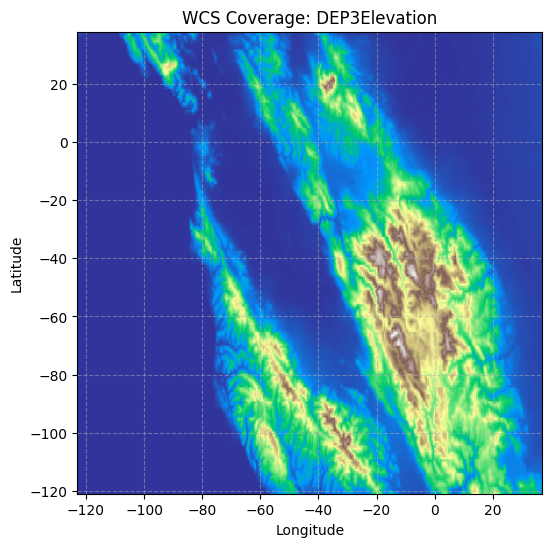

In [83]:
bbox_us_example = [-123.0, 37.0, -121.0, 38.0]  # Area around San Francisco, CA

# Perform GetCoverage request (WCS 1.0.0 parameters)
getcov = wc.getCoverage(
    identifier=cov_id,
    bbox=bbox_us_example,
    crs="EPSG:4326",
    format="GeoTIFF",
    resx=0.005,
    resy=0.005
)

# Read the response as TIFF
img_data = getcov.read()
img = imread(BytesIO(img_data))

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(img, extent=bbox_us_example, cmap="terrain")
plt.title(f"WCS Coverage: {cov_id}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## STAC Collections and Items Inspection

In [18]:
collections_response = requests.get(f"{data_access_domain}/stac/collections")
collections = collections_response.json()
print("Collections:")
for collection in collections['collections']:
    print(f" - {collection['id']}")

Collections:
 - noaa-emergency-response
 - sentinel-2-iceland


## Load and Inspect Sample STAC Collection and Items

In [84]:
collections_url = "https://raw.githubusercontent.com/EOEPCA/deployment-guide/main/scripts/data-access/collections/sentinel-2-iceland/collections.json"
items_url = "https://raw.githubusercontent.com/EOEPCA/deployment-guide/main/scripts/data-access/collections/sentinel-2-iceland/items.json"

collections_json = requests.get(collections_url).json()
items_json = requests.get(items_url).json()

## Ingestion of Sample Collection and Items

In [85]:
collections_endpoint = f"{data_access_domain}/stac/collections"
ingested_collection = requests.post(collections_endpoint, json=collections_json)
print(f"Collection ingestion status code: {ingested_collection.status_code}")
print(ingested_collection.json())

items_endpoint = f"{data_access_domain}/stac/collections/{collections_json['id']}/items"

successful_items = []
failed_items = []

# only take first 5 items for testing
items_json = items_json[:5]

for item in items_json:
    response = requests.post(items_endpoint, json=item)
    if response.status_code == 200:
        successful_items.append(item['id'])
    else:
        failed_items.append((item['id'], response.text))

print(f"Successfully ingested items: {successful_items}")
if failed_items:
    print(f"Failed items: {failed_items}")

Collection ingestion status code: 201
{'id': 'sentinel-2-iceland', 'description': 'Sentinel-2 data from 2023 over Iceland.', 'stac_version': '1.0.0', 'links': [{'rel': 'items', 'type': 'application/geo+json', 'href': 'https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland/items'}, {'rel': 'parent', 'type': 'application/json', 'href': 'https://eoapi.test.eoepca.org/stac/'}, {'rel': 'root', 'type': 'application/json', 'href': 'https://eoapi.test.eoepca.org/stac/'}, {'rel': 'self', 'type': 'application/json', 'href': 'https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland'}, {'href': 'https://eoapi.test.eoepca.org/stac/items.json', 'rel': 'items', 'type': 'application/geo+json'}, {'href': 'https://doi.org/10.5270/S2_-742ikth', 'rel': 'cite-as', 'title': 'Copernicus Sentinel-2 MSI Level-2A (L2A) Bottom-of-Atmosphere Radiance'}, {'href': 'https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice', 'rel': 'license', 'title': 'proprietary'}], 'stac_exte

## STAC Items Search and Visualization (Post-Ingestion)

In [86]:
collection_check = requests.get(f"{collections_endpoint}/{collections_json['id']}")
print(f"Collection retrieval status: {collection_check.status_code}")

items_check = requests.get(items_endpoint)
print(f"Items retrieval status: {items_check.status_code}")

Collection retrieval status: 200
Items retrieval status: 200


In [90]:
search_url = f"{data_access_domain}/stac/search"
search_payload = {
    "bbox": [-25, 63, -24, 65],
    "datetime": "2023-01-01T00:00:00Z/2024-01-01T00:00:00Z",
    "limit": 5
}

response = requests.post(search_url, json=search_payload)
search_results = response.json()
for feature in search_results['features']:
    print(f"Found item: {feature['id']} with datetime {feature['properties']['datetime']}")
    print(f"Link to item: {feature['links'][0]['href']}")
    print(f"Link to collection: {feature['links'][1]['href']}")
    print()

Found item: S2A_26WPS_20231109_0_L2A with datetime 2023-11-09T13:33:54.673000Z
Link to item: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland
Link to collection: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland

Found item: S2B_26WPS_20231108_0_L2A with datetime 2023-11-08T13:14:03.373000Z
Link to item: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland
Link to collection: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland

Found item: S2B_26WNT_20231108_0_L2A with datetime 2023-11-08T13:13:54.912000Z
Link to item: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland
Link to collection: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland

Found item: S2B_26WPT_20231108_0_L2A with datetime 2023-11-08T13:13:52.199000Z
Link to item: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland
Link to collection: https://eoapi.test.eoepca.org/stac/collections/sentinel-2-iceland



In [91]:
if search_results['features']:
    stac_item = search_results['features'][0]
    visual_asset_url = stac_item['assets']['visual']['href']
    print(f"Visual asset URL: {visual_asset_url}")

    # image_response = requests.get(visual_asset_url)
    # img = Image.open(BytesIO(image_response.content))

    # plt.figure(figsize=(8, 8))
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title(f"Raster Visualization: {stac_item['id']}")
    # plt.show()
else:
    print("No STAC items found.")

Visual asset URL: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/26/W/PS/2023/11/S2A_26WPS_20231109_0_L2A/TCI.tif


## Raster and Vector API Availability Checks

In [92]:
raster_health_url = f"{data_access_domain}/raster/healthz"
vector_health_url = f"{data_access_domain}/vector/healthz"

raster_health = requests.get(raster_health_url)
vector_health = requests.get(vector_health_url)

print(f"Raster API Health Check: {raster_health.status_code} - {raster_health.text}")
print(f"Vector API Health Check: {vector_health.status_code} - {vector_health.text}")


Raster API Health Check: 200 - {"database_online":true}
Vector API Health Check: 200 - {"ping":"pong!"}


## STAC Manager UI Check

In [93]:
stac_manager_ui_url = data_access_domain
response = requests.get(stac_manager_ui_url)
print(f"STAC Manager UI status code: {response.status_code}")
response.url

STAC Manager UI status code: 200


'https://eoapi.test.eoepca.org/'